EOF
Top-1024,Sketch:8*2688
Execution time:  31.821 seconds.
Precision:  0.745
Top_dict with 36968 bytes.
Sketch with 86128 bytes.
Sk_head with 1504 bytes.
Total size 124600 bytes, 


lhh_are:0.8980739893211289,lhh_aae:15.125
lhh over_estimate:4, lhh under_estimate:117
sketch over_estimate:9580, sketch under_estimate:107765
Find:763, TP:763, FP:261
Top_ARE: 0.062233
Top_AAE: 3.326343
all_ARE: 0.049298
all_AAE: 0.193636
Estimate time:   9.558 seconds.


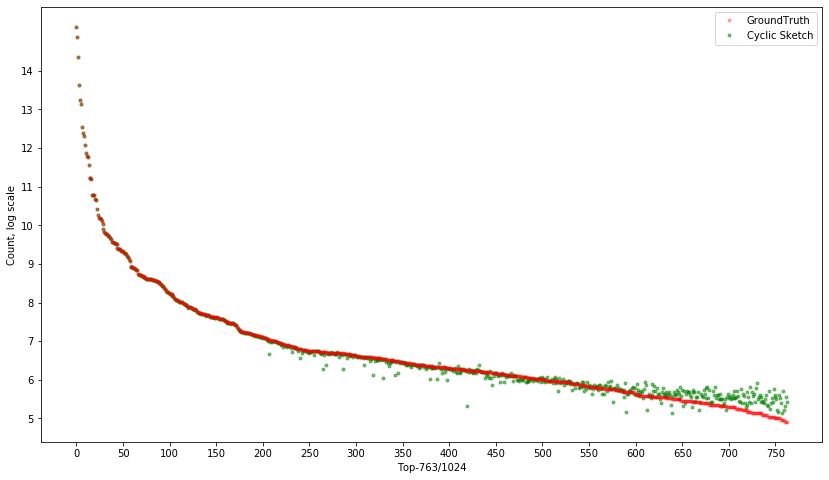

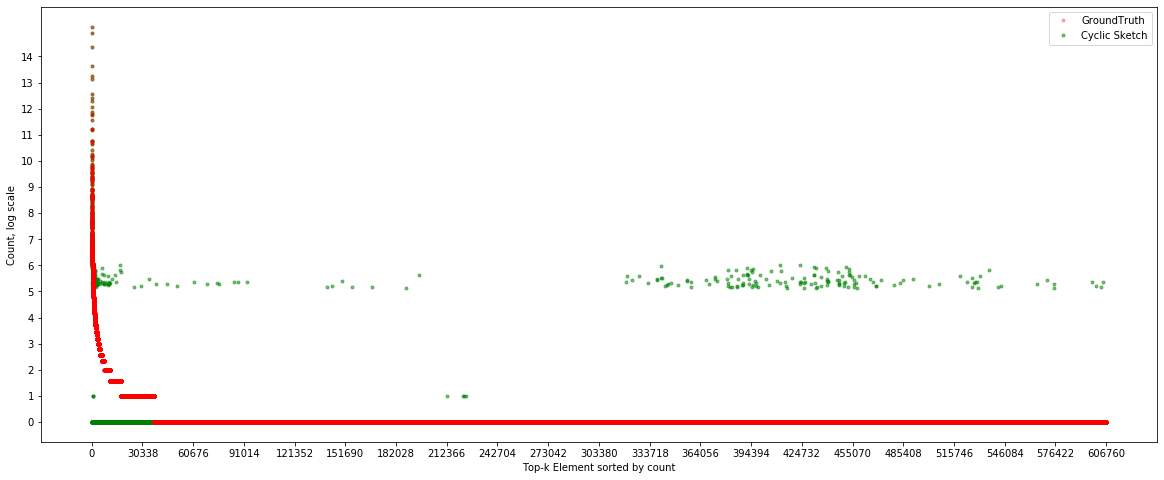

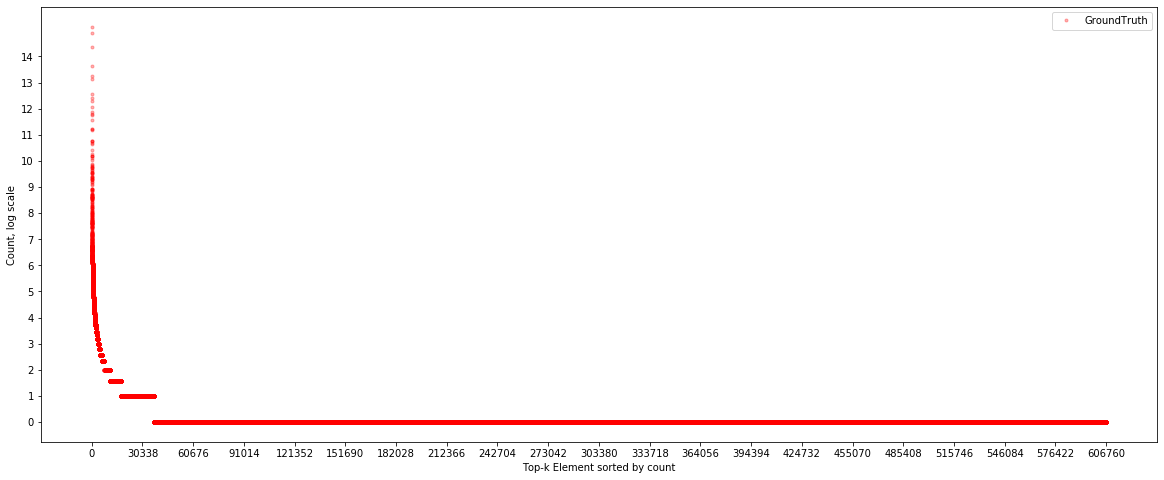

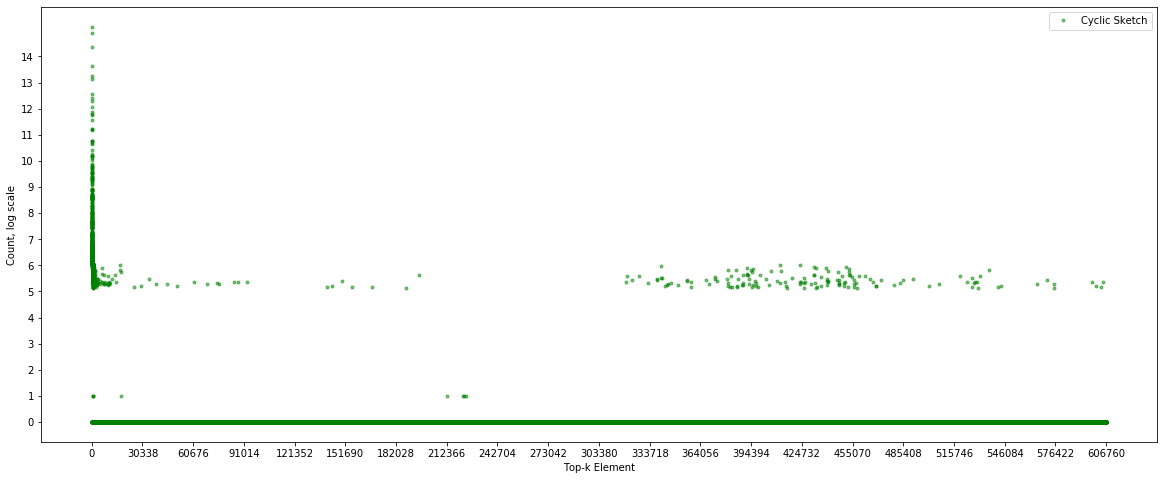

In [1]:
# ver 20210829 rewrite


from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys

import tracemalloc

tracemalloc.start()
    # start track memory usage===========================================================

filename='kosarak.dat'
filepath=r"..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth
w=2688
d=8
size=1024
topk=1024
Config.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth

Sk_head=[DS.Head(0) for j in range(Config.depth)]
Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

    
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            item=DS.Tail(e,1)
            if Top_dict.get(item.ID):
                # e in Top
                Top_dict[item.ID]+=1
            else:
                if len(Top_dict)<Config.size:
                    Top_dict[item.ID]=1
                else:
                    Func.UpdateSk(item,Sk_head,Sketch)
        if Config.e_max.count>e_min.count:
            min_ele = min(Top_dict, key=Top_dict.get)
                # 找dict中的最小key元素
            e_min=DS.Tail(min_ele,Top_dict[min_ele])
            Func.BringBack(e_min,Top_dict,Sk_head,Sketch)
end=time.time()

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
    # stop track memory usage===========================================================

print("Top-{},Sketch:{}*{}".format(Config.size,Config.depth,Config.width))
print("Execution time:{:8.3f} seconds.".format(end-start))
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
tp_set,precision=Func.Get_precision(gr_path,Top_dict,Config.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))

print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("Sketch with {} bytes.".format(sys.getsizeof(Sketch)))

sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*Config.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE

startx=time.time()
print("\n")
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,9)
endx=time.time()
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx)) 
'''
startx=time.time()
print("\n")
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,10)
endx=time.time()
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx)) 
'''

Func.Plot_topk_compare(gr_path,Top_dict,"Cyclic Sketch")

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=Func.single_query(item,Top_dict,Sk_head,Sketch,cardinality)

Func.Plot_all_compare(ground_truth,My_result,"Cyclic Sketch")

In [2]:
import linecache
import os
import tracemalloc

def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))


display_top(snapshot)

Top 10 lines
#1: C:\ProgramData\Anaconda3\lib\selectors.py:314: 144.1 KiB
    r, w, x = select.select(r, w, w, timeout)
#2: <ipython-input-1-b5be9fed8a63>:35: 86.3 KiB
    Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
#3: <frozen importlib._bootstrap_external>:487: 73.3 KiB
#4: C:\Users\PERO\Python\Proposal\20210718\Tools\Func.py:78: 72.0 KiB
    Top[Config.e_max.ID]=Config.e_max.count
#5: C:\ProgramData\Anaconda3\lib\site-packages\Crypto\Random\Fortuna\FortunaGenerator.py:63: 64.0 KiB
    _four_kiblocks_of_zeros = b("\0") * block_size * 4096
#6: <ipython-input-1-b5be9fed8a63>:43: 63.1 KiB
    e=file.readline().strip('\n')
#7: C:\ProgramData\Anaconda3\lib\site-packages\hyperloglog\hll.py:91: 33.3 KiB
    self.M = [ 0 for i in range(self.m) ]
#8: <frozen importlib._bootstrap_external>:1310: 8.7 KiB
#9: C:\ProgramData\Anaconda3\lib\site-packages\Crypto\Hash\hashalgo.py:49: 6.7 KiB
    self._hash = hashFactory()
#10: <frozen importlib._bootstrap_external>:60: 5.7 KiB
282 othe

In [ ]:
# 
from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys



def main():
    # set dataset and ground truth file path
    filename='kosarak.dat'
    filepath=r"..\dataset\kosarak"
    gr_file_name='kosarak_ground_truth.csv'
    src_data=os.path.join(filepath,filename)
        # dataset path
    gr_path=os.path.join(filepath,gr_file_name)
        # ground truth path
    
    # Top and Sketch parameter config
    w=1024
    d=1024
    size=1024
    Config.Set_default(w,d,size)
        # set width, depth, size of Sk, random seed of hash,e_max
    
    # Initialize Top, Sketch and Sk_head
    Sk_head=[DS.Head(0) for j in range(Config.depth)]
    Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
    Top_dict=dict()
    e_min=DS.Tail("",1)
    
    # Stream processing
    start=time.time()
    with open(src_data,'r') as file:
        while True:
            e=file.readline().strip('\n')
            if not e:
                print('EOF')
                break
            else:
                item=DS.Tail(e,1)
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<Config.size:
                        Top_dict[item.ID]=1
                    else:
                        Func.UpdateSk(item,Sk_head,Sketch)                
            if Config.e_max.count>e_min.count:
                min_ele = min(Top_dict, key=Top_dict.get)
                    # 找dict中的最小key元素
                e_min=DS.Tail(min_ele,Top_dict[min_ele])
                Func.BringBack(e_min,Top_dict,Sk_head,Sketch)
    end=time.time()
    print("Top-{},Sketch:{}*{}".format(Config.size,Config.depth,Config.width))
    print("Execution time:{:8.3f} seconds.".format(end-start))
    Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
    
    # Element-Precision
    tp_set,precision=Func.Get_precision(gr_path,Top_dict)
    print("Precision: {:7.4f}".format(precision))
    
    # Count ARE/AAE
    startx=time.time()
    top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,4)
    endx=time.time()
    print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
    print("Top_ARE: {:8.6f}".format(top_are))
    print("Top_AAE: {:8.6f}".format(top_aae))
    print("all_ARE: {:8.6f}".format(all_are))
    print("all_AAE: {:8.6f}".format(all_aae))
    print("Estimate time:{:8.3f} seconds.".format(endx-startx))
    
    # Count ARE/AAE
    startx=time.time()
    top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,5)
    endx=time.time()
    print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
    print("Top_ARE: {:8.6f}".format(top_are))
    print("Top_AAE: {:8.6f}".format(top_aae))
    print("all_ARE: {:8.6f}".format(all_are))
    print("all_AAE: {:8.6f}".format(all_aae))
    print("Estimate time:{:8.3f} seconds.".format(endx-startx))
    
if __name__=='__main__':
    main()

In [ ]:
# about data set
filename='kosarak.dat'
filepath=r"..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)

distinct=set()
item_count=0

start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            item_count+=1
            if e not in distinct:
                # e in Top
                distinct.add(e)
    print(len(distinct))
    print(item_count)
end=time.time()

In [ ]:
print("Sum of Sketch row")
for i in range(len(Sk_head)):
    print(Sk_head[i].count,end=',')
print("\nNumner of distinct elements:")
for i in range(len(Sk_head)):    
    print(len(Sk_head[i].distinct),end=',')
print("\nAvg count for an element in cell:")
for i in range(len(Sk_head)):
    print("{}".format(int(Sk_head[i].count/len(Sk_head[i].distinct))),end=',')
        # int()會無條件捨去

In [ ]:
# compare top k

grtruth=pd.read_csv(gr_path)
grtruth['Element'] = grtruth['Element'].astype(str)
gt_dict=dict(grtruth[:Config.size].values.tolist())
gt_dict

tp_set=Top_dict.keys() & gt_dict.keys()
print("Top_dict vs. gt_dict:")
smaller=0
bigger=0
for item in tp_set:
    if Top_dict[item]<gt_dict[item]:
        smaller+=1
        print("item:{}:".format(item))
        print('count:{},{}'.format(Top_dict[item],gt_dict[item]))
    elif Top_dict[item]>gt_dict[item]:
        bigger+=1
        print("item:{}:".format(item))
        print('count:{},{}'.format(Top_dict[item],gt_dict[item]))        
print(smaller,bigger)


In [ ]:
grtruth=pd.read_csv(gr_path)
grtruth['Element'] = grtruth['Element'].astype(str)
gt_dict=dict(grtruth[:].values.tolist())

row_cardinality=[len(i.distinct) for i in Sk_head]
print("Estimated vs. Ground Truth:")
smaller=0
bigger=0
for item in Sk_head:
    if item.maxID:
        count_estimate=Func.Query5(item.maxID,Top_dict,Sk_head,Sketch,row_cardinality)
        if count_estimate<gt_dict[item.maxID]:
            smaller+=1

        elif count_estimate>gt_dict[item.maxID]:
            bigger+=1
    '''
    print("{}:".format(item.maxID))
    print("{} vs. {}".format(gt_dict[item.maxID],count_estimate))    
    '''
print(smaller,bigger)

In [ ]:
## gpro2dot + graphviz的指令
執行並輸出.out檔：
python -m cProfile -o es.out webdocs.py
產生圖形：
python -m gprof2dot -f pstats es.out | dot -T png -o es.png

In [ ]:
import math, heapq

class SpaceSavingCounter:
    def __init__(self, eps):
        self.k = math.ceil(1/eps)
        self.n = 0
        self.counts = dict()
        self.queue = []

    def inc(self, x):
        # increment total elements seen
        self.n += 1

        # x is being watched
        if x in self.counts:
            self.counts[x] += 1

        # x is not being watched
        else:
            # make room for x
            if self.n > self.k:
                while True:
                    count, tstamp, key = self.pop()
                    assert self.counts[key] >= count
                    if self.counts[key] == count:
                        del self.counts[key]
                        break
                    else:
                        self.push(self.counts[key], tstamp, key)
            else:
                count = 0

            # watch x
            self.counts[x] = count + 1
            self.push(count, self.n, x)


    def push(self, count, tstamp, key):
        heapq.heappush(
            self.queue,
            (count, tstamp, key)
        )

    def pop(self):
        return heapq.heappop(self.queue)

def test_SpaceSavingCounter():
    seq = [1,5,3,4,2,7,7,1,3,1,3,1,3,1,3]
    counter = SpaceSavingCounter(1 / 1.9)
    for x in seq:
        counter.inc(x)
    assert counter.counts.keys() == {1,3}